<a href="https://colab.research.google.com/github/wcl20/PyTorch-DCGAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch DCGAN

## 1. Setup

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# Set random seed to make results reproducible
torch.manual_seed(0)
if torch.cuda.is_available():
  torch.cuda.manual_seed(0)
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using GPU: {torch.cuda.is_available()}")

Using GPU: True


## 2. Load Data

### 2.1 Upload Kaggle API

In [0]:
files.upload()

### 2.2 Fetch Data

In [0]:
# Install Kaggle
! pip install -U -q kaggle
# Create Kaggle Directory
! mkdir -p ~/.kaggle
# Copy API key to Kaggle Directory
! cp kaggle.json ~/.kaggle/
# Change permission of file
! chmod 600 ~/.kaggle/kaggle.json
# Download dataset
! kaggle datasets download -d splcher/animefacedataset
! unzip animefacedataset.zip -d data

### 2.3 Create Dataset

In [0]:
# Create Data Directory
data_dir = "data/"
dataset = datasets.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                  transforms.Resize((64, 64)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                           
                               ]))

### 2.4 Create DataLoader

In [0]:
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

### 2.5 Visualize Dataset

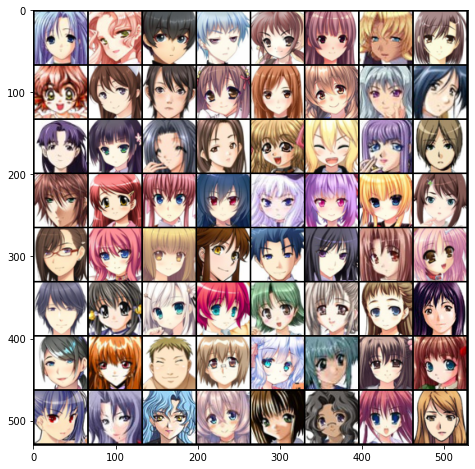

In [6]:
# Get first batch from train loader
images, labels = next(iter(train_loader))
# Create figure
plt.figure(figsize=(8,8))
images = make_grid(images.to(device)[:64], padding=2, normalize=True)
if torch.cuda.is_available():
  images = images.cpu()
images = np.transpose(images.numpy(), (1, 2, 0))
# Show images
plt.imshow(images)

## 3. Define Model

### 3.1 Generator

In [0]:
class Generator(nn.Module):
  def __init__(self, in_dim=100):
    super(Generator, self).__init__()
    # N x 100
    self.hidden0 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_dim, out_channels=1024, kernel_size=4),
        nn.BatchNorm2d(1024),
        nn.ReLU(True))
    # N x 4 x 4 x 1024
    self.hidden1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True))
    # N x 8 x 8 x 512
    self.hidden2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True))
    # N x 16 x 16 x 256
    self.hidden3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True))
    # N x 32 x 32 x 128
    self.hidden4 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
        nn.Tanh())
    # N x 64 x 64 x 3
  
  def forward(self, x):
    output = self.hidden0(x)
    output = self.hidden1(output)
    output = self.hidden2(output)
    output = self.hidden3(output)
    output = self.hidden4(output)
    return output


### 3.2 Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # N x 64 x 64 x 3
    self.hidden0 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, True))
    # N x 32 x 32 x 64
    self.hidden1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, True))
    # N x 16 x 16 x 128
    self.hidden2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, True))
    # N x 8 x 8 x 256
    self.hidden3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, True))
    # N x 4 x 4 x 512
    self.hidden4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4),
        nn.Sigmoid())
    # N x 1 x 1 x 1
  
  def forward(self, x):
    output = self.hidden0(x)
    output = self.hidden1(output)
    output = self.hidden2(output)
    output = self.hidden3(output)
    output = self.hidden4(output)
    return output.flatten()

### 3.3 Weight Initialization
In the DCGAN paper, all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. This applies to all convolutional, convolutional-transpose, and batch normalization layers.

In [0]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [10]:
# Initialize Generator
model_G = Generator().to(device)
model_G.apply(weights_init)
print(model_G)

Generator(
  (hidden0): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden4): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=

In [11]:
# Initialize Discriminator
model_D = Discriminator().to(device)
model_D.apply(weights_init)
print(model_D)

Discriminator(
  (hidden0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (hidden1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (hidden2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (hidden3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True

## 4. Train Model

### 4.1 Define Hyperparmeters

In [0]:
# Learning rate
lr = 0.0005
# Epochs
epochs = 10

### 4.2 Define Optimizer

In [0]:
optimizer_G = optim.Adam(model_G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(model_D.parameters(), lr=lr, betas=(0.5, 0.999))

### 4.3 Define Loss Function

In [0]:
criterion = nn.BCELoss()

### 4.4 Model Training

In [15]:
# Establish convention for real and fake label
real_label = 1
fake_label = 0
for epoch in range(epochs):
  print(f"Epoch: {epoch + 1}")
  for batch_idx, (images, _) in enumerate(train_loader):
    ####################################################
    # Train Discriminator
    ####################################################
    # Train with real data
    real_images = images.to(device)
    # Create labels indicating real data
    batch_size = real_images.size(0)
    labels = torch.full((batch_size,), real_label, device=device)
    # Real batch forward pass
    model_D.zero_grad()
    output = model_D(real_images)
    # Compute loss
    loss = criterion(output, labels)
    loss.backward()
    
    # Train with fake data
    noise = torch.randn(batch_size, 100, 1, 1, device=device)
    # Generate fake images from noise
    fake_images = model_G(noise)
    # Create labels indicating fake data
    labels.fill_(fake_label)
    # Fake batch forward pass
    output = model_D(fake_images.detach())
    # Compute loss
    loss = criterion(output, labels)
    loss.backward()
    # Train Discriminator
    optimizer_D.step()

    ####################################################
    # Train Generator
    ####################################################
    model_G.zero_grad()
    # Discriminate fake images
    output = model_D(fake_images)
    # Create labels (We want model_D to think images are real)
    labels.fill_(real_label)
    # Compute loss 
    loss = criterion(output, labels)
    loss.backward()
    # Train Generator
    optimizer_G.step()




Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


## 5. Test Model

### 5.1 Visualise Generated Data

In [0]:
# Rescale [-1, 1] to [0, 1]
def denorm(x):
  x = 0.5 * (x + 1)
  x = x.clamp(0, 1)
  return x

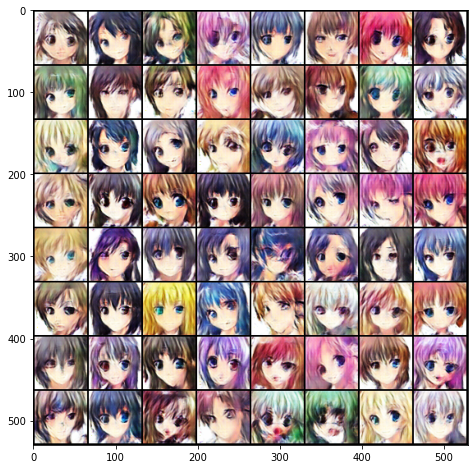

In [17]:
noise = torch.randn(64, 100, 1, 1, device=device)
with torch.no_grad():
  # Create figure
  plt.figure(figsize=(8,8))
  images = model_G(noise)
  images = make_grid(denorm(images).to(device)[:64], padding=2, normalize=True)
  if torch.cuda.is_available():
    images = images.cpu()
  images = np.transpose(images.numpy(), (1, 2, 0))
  # Show images
  plt.imshow(images)

## 6. Save Model

In [0]:
torch.save(model_G.state_dict(), "model_G.pt")
torch.save(model_D.state_dict(), "model_D.pt")